## Στοιχεία Ομάδας

Αριθμός Ομάδας: Μ.Α.11

    > Καρυπιάδης Ευστράτιος: 03114911

In [0]:
import warnings
warnings.filterwarnings('ignore')

---

## 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο

<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="85%">

---

### Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset στο dataframe `df_data_1`: 

In [0]:
import pandas as pd

dataset_url = 'data/movieDBe.csv'
df_data_1 = pd.read_csv(dataset_url, sep='\t', header=None, quoting=3, error_bad_lines=False)

Θα δουλέψουμε σε ένα υποσύνολο 5.000 ταινιών ανάλογα με το seed της ομάδας μας:

In [0]:
import numpy as np

# Seed Number: 11
team_seed_number = 11

movie_seeds_url = 'data/seeds2019.csv'
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

my_index = df_data_2.iloc[team_seed_number, :].values

titles = df_data_1.iloc[:, [2]].values[my_index]
categories = df_data_1.iloc[:, [3]].values[my_index]
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index]
summaries =  df_data_1.iloc[:, [5]].values[my_index] 
corpus = summaries[:, 0].tolist() # list form of summaries

- Ο πίνακας `titles` περιέχει τους τίτλους των ταινιών.

- O πίνακας `categories` περιέχει τις κατηγορίες της ταινίας υπό τη μορφή string. Παρατηρούμε ότι είναι μια comma-separated λίστα strings, με κάθε string να είναι μια κατηγορία.

- Ο πίνακας `catbins` περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή μέσω *One-Hot-Encoding*.

- Ο πίνακας `summaries` και η λίστα `corpus` περιλαμβάνουν τις συνόψεις των ταινιών με την corpus είναι ο πίνακας summaries σε μορφή λίστας. Κάθε σύνοψη είναι σε μορφή string.

- Θεωρούμε ως `id` της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας.

Στη συνέχεια της άσκησης θα υλοποιήσουμε ένα *Content Based Recommender System*.

---

### Μετατροπή σε TF - IDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψουμε το corpus σε αναπαράσταση *Term Frequency-Inverse Document Frequency (TF-IDF)*:

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

Σημειώνουμε πως η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ δεν είναι βελτιστοποιημένη.

In [5]:
corpus_tf_idf.shape

(5000, 48526)

---

### Υλοποίηση Συστήματος Συστάσεων

Θα δημιουργήσουμε τη συνάρτηση `content_recommender` με ορίσματα `target_movie` και `max_recommendations`. Πιο συγκεκριμένα, θα υπολογίζουμε για κάθε ταινία-στόχο την [ομοιότητα συνημιτόνου](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) από το `corpus_tf_idf` με όλες τις υπόλοιπες ταινίες, ενώ στη συνέχεια θα ταξινομούμε τις αντίστοιχες ομοιότητες ως προς το *index* της εκάστοτε ταινίας. Η συνάρτησή μας θα επιστρέφει το id, τον τίτλο, την κατηγορία και τη σύνοψη τόσο της ταινίας-στόχου, όσο και των `max_recommendations` συναφών ταινιών.

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

def content_recommender(target_movie, max_recommendations):
    """ Returns ID, Title, Genre and Summary of target_movie and #max_recommendation movies respectively. 
    Metric used: Cosine Similarity. """
    
    distances = np.zeros((corpus_tf_idf.shape[0]))
    for i in range(corpus_tf_idf.shape[0]):
        distances[i] = cosine_similarity(corpus_tf_idf[target_movie], corpus_tf_idf[i])
        
    distances_slices = np.argsort(distances) # ascending order of indexes
    distances_slices_descending = distances_slices[::-1]
    
    result = distances_slices_descending[:max_recommendations+1]
    
    for movie in result:
        yield("ID: " + str(movie) +" - Movie Title: " + titles[movie][0] + " - Genre: " + categories[movie][0] + "\n" + summaries[movie][0] + "\n\n")

Θα δοκιμάσουμε τη συνάρτηση στην ταινία [Ring 2](https://imdb.to/39QqbSS).

In [9]:
for recommendation in content_recommender(3401, 5):
    print(recommendation)

ID: 3401 - Movie Title: Ring 2 - Genre: "Japanese Movies",  "Horror",  "World cinema",  "Supernatural"
While inspecting the corpse of Sadako Yamamura, the forensic experts note evidence that Sadako has died only a year or two ago, meaning that she was still alive in the sealed well for almost thirty years. They later reconstruct her body and send it to Takaishi Yamamura , Sadako's uncle, who takes it on his boat and later casts it into the bottom of the ocean. Mai Takano , Ryuji Takayama's assistant, continues to search for answers in regards to his sudden death. She meets a reporter named Okazaki , while looking for Ryuji's ex-wife Reiko Asakawa , who is investigating the cursed tape in Reiko's stead. Okazaki, still searching for a person who has actually seen the tape with their own eyes, tracks down and interviews a girl named Kanae Sawaguchi . Although she has not yet seen the tape, she agrees to sell him a copy for ¥20,000. Upon giving the tape to Okazaki, Kanae admits that she wa

Παρατηρούμε ότι οι προτεινόμενες ταινίες δε φαίνεται να είναι σχετικές με το περιεχόμενο της ταινίας-στόχου, ενώ μια κοινή θεματική θα μπορούσε να είναι ο όρος **kill**. Γενικά η συνάρτηση συστάσεων σε συνδυασμό με τα δεδομένα στην παρούσα μορφή τους, δεν παρουσιάζουν ικανοποιητική απόδοση. Για αυτό το σκοπό θα προεπεξεργαστούμε το σύνολο των δεδομένων μας και θα επιχειρήσουμε να βελτιώσουμε την αρχικοποίηση του `TfidfVectorizer`.

---

### Βελτιστοποίηση

Προς βελτίωση της συνάρτησης συστάσεων θα εισάγουμε αρχικά το σύνολο `stopwords`, μέσω του οποίου θα φιλτράρουμε το συνολικό μας `corpus`, ώστε να εξάγουμε από αυτό λέξεις με υψηλή συχνότητα εμφάνισης που σε γενικές γραμμές δεν είναι αντιπροσωπευτικές του βασικού περιεχομένου μίας ταινίας:

In [0]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)

stopwords_acc = stopwords.words('english')

Στη συνέχεια θα ακολουθήσουμε τη διαδικασία [Stemming](https://en.wikipedia.org/wiki/Stemming). Για αυτό το σκοπό θα χρησιμοποιήσουμε τον `SnowballStemmer`. Αποτέλεσμα της διαδικασίας θα είναι η λίστα `corpus_stem`, η οποία βρίσκεται στην ακριβώς ίδια μορφή με την αρχική λίστα `corpus`, με μοναδική διαφορά εκείνη των επεξεργασμένων λέξεων. Σημειώνουμε ότι θα περάσουμε και το σύνολο `stopwords_acc` από τον `SnowballStemmer`, ώστε να είναι αποδοτική η μελλοντική μετατροπή του `corpus_stem` σε `corpus_tf_idf`.

In [0]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

corpus_stem_split = [[stemmer.stem(word) for word in summary.split(" ")] for summary in corpus]
corpus_stem = [" ".join(sentence) for sentence in corpus_stem_split]

stopwords_acc_stem = [stemmer.stem(word) for word in stopwords_acc]

Συνεχίζουμε με την υλοποίηση της συνάρτηση `fetch_most_frequend_words`, η οποία επιστρέφει τις `n` τω πλήθος πιο συχνές λέξεις των συνόψεων των ταινιών μας. Σημειώνουμε ότι από τις παραπάνω λέξεις θα αγνοήσουμε εκείνες που ανήκουν στο σύνολο `stopwords_acc_stem`, ώστε να προσαρμόσουμε τα αποτελέσματά μας στα πλαίσια των ταινιών και κατά συνέπεια στα δεδομένα μας.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

# Source: https://bit.ly/2TcFm2L
def fetch_most_frequent_words(corpus, n=None):
    """ Returns a list of most common words found in given corpus plus their respective values.
    Stopwords for nltk package are excluded. """
    
    vec = CountVectorizer(stop_words=stopwords_acc_stem).fit(corpus)  # ignore stopwords
    bag_of_words = vec.transform(corpus)
    
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

Αρχικά θα εξετάσουμε τις λέξεις εκείνες που εμφανίζονται σε περισσότερες από 500 συνόψεις, τις οποίες θα αξιολογήσουμε ώστε να αποφανθούμε σχετικά με την εισαγωγή τους στο τελικό σύνολο `final_stopwords` που θα χρησιμοποιήσουμε. Κατά την αξιολόγηση θα προσπαθήσουμε να συμπεριλάβουμε εκείνες μονάχα τις λέξεις που η αφαίρεσή τους δε θα αλλοιώνει το βασικό πλαίσιο της ταινίας. Αξίζει να παρατηρήσουμε ότι αυτή η διαδικασία είναι "χειροκίνητη" και όχι απαραίτητα άρτια, δεδομένου ότι η προσωπική μας κρίση για την αφαίρεση ή όχι μιας λέξης μπορεί τελικά να αποδειχθεί λανθασμένη.

In [13]:
most_freq = []
for word, freq in fetch_most_frequent_words(corpus_stem):
    if freq >= 500:
        most_freq.append((word, freq))
print(most_freq)

[('find', 3934), ('get', 3902), ('one', 3894), ('take', 3536), ('kill', 3386), ('tell', 3036), ('back', 2885), ('tri', 2762), ('film', 2739), ('two', 2616), ('father', 2600), ('make', 2532), ('love', 2473), ('man', 2328), ('leav', 2309), ('time', 2255), ('becom', 2250), ('go', 2240), ('see', 2224), ('come', 2176), ('return', 2133), ('new', 2107), ('friend', 2006), ('meet', 1981), ('life', 1981), ('help', 1966), ('day', 1963), ('home', 1955), ('end', 1943), ('later', 1928), ('also', 1878), ('begin', 1816), ('decid', 1796), ('mother', 1784), ('work', 1756), ('use', 1743), ('however', 1675), ('live', 1657), ('call', 1638), ('give', 1637), ('year', 1634), ('name', 1630), ('run', 1613), ('young', 1606), ('goe', 1576), ('ask', 1485), ('wife', 1483), ('fall', 1480), ('attempt', 1479), ('son', 1478), ('famili', 1472), ('first', 1462), ('show', 1455), ('girl', 1449), ('reveal', 1445), ('away', 1444), ('turn', 1442), ('start', 1415), ('way', 1405), ('discov', 1395), ('old', 1393), ('night', 1392

Μελετώντας τα παραπάνω θα δημιουργήσουμε τη λίστα `usefull_acc`, στην οποία θα προσθέσουμε λέξεις που θεωρούμε πως έχουν βαρύτητα στην υπόθεση της ταινίας και δε θα ήταν αποδοτικό να αφαιρεθούν κατά την υλοποίηση του συστήματος συστάσεών μας. Στη συνέχεια, θα συνθέσουμε το σύνολο `final_stopwords`, στο οποίο θα ανήκουν λέξεις από την ένωση των συνόλων `stopwords_acc_stem` και `usefull_acc_stem`.

In [0]:
usefull = ['kill', 'father', 'love', 'new', 'friend', 'return', 'life', 'help', 'home', 'mother', 'run', 'young', 'wife', 'fall', 'attempt', 'son', 'famili', 'work', 'discov', 'polic', 'death', 'fight', 'attack', 'car', 'daughter', 'forc', 'brother', 'money', 'plan', 'hous', 'marri', 'murder', 'town', 'escap', 'school', 'girl', 'boy', 'group', 'world', 'die', 'room', 'dead', 'save', 'shoot', 'visit', 'children', 'husband', 'sister', 'hand', 'house', 'break', 'war', 'last', 'local', 'sever', 'feel', 'job', 'fire', 'train', 'secret', 'offer', 'face', 'offic', 'refus', 'team', 'gang', 'drive', 'gun', 'relationship', 'child', 'power', 'ship', 'chase', 'confront', 'travel', 'shot', 'parent', 'villag', 'destroy', 'win', 'former', 'search', 'american', 'bodi', 'dog', 'land', 'allow', 'success', 'family', 'lose', 'prison', 'rescu', 'accident', 'doctor', 'student', 'water', 'citi']
usefull_acc_stem = set(usefull)

most_freq_acc_stem = []
for word in most_freq:
    most_freq_acc_stem.append(word[0])

final_stopwords = set(stopwords_acc_stem + most_freq_acc_stem)

for word in usefull_acc_stem:
    final_stopwords.remove(word)

Σε αυτό το σημείο ολοκληρώσαμε τη διαδικασία της προεπεξεργασίας των δεδομένων μας. Θα συνεχίσουμε με τη βελτιστοποίηση του `TfidfVectorizer`. Πιο συγκεκριμένα, δεδομένης της παραπάνω διαδικασίας δε θα πειραματιστούμε με το όρισμα `max_df`, καθώς κάτι τέτοιο θα αφαιρούσε χρήσιμες, κατά την κρίση μας, λέξεις και συνολικά θα ακύρωνε τη λογική της υλοποίησής μας. Επίσης, δε θα χρειαστούμε και το όρισμα `lowercase`, καθώς οι λέξεις μας αποτελούνται ήδη από πεζά γράμματα έπειτα από τη διαδικασία *Stemming*. Τελικά, αρκεί να δοκιμάσουμε διαφορετικές τιμές για το όρισμα `min_df`.

In [189]:
import joblib

vectorizer = TfidfVectorizer(stop_words=final_stopwords, min_df=5)

vectorizer.fit(corpus_stem)
corpus_tf_idf = vectorizer.transform(corpus_stem)

# Saving corpus_tf_idf
joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 

['corpus_tf_idf.pkl']

In [190]:
corpus_tf_idf.shape

(5000, 10914)

Παρατηρούμε ότι η παραπάνω προσέγγιση μειώνει τα χαρακτηριστικά μας κατά περίπου 30.000.

---

### Επεξήγηση Επιλογών, Ποιοτική Ερμηνεία και Παρατηρήσεις

Κατά τη βελτίωση του `TfidfVectorizer` επιλέξαμε, όπως αναφέραμε και παραπάνω να μην μεταβάλλουμε το όρισμα `max_df`. Η προσέγγιση που επιλέξαμε είναι να αφαιρέσουμε τις πιο συχνά εμφανιζόμενες λέξεις, που όμως κατά τη γνώμη μας δε συνεισφέρουν στη σκιαγράφηση του πλαισίου μιας ταινίας. Κατά αυτόν τον τρόπο δεν αγνοούμε όρους που συνθέτουν το κεντρικό πλαίσιο ενός σεναρίου, εκτειθόμεθα ωστόσο στον κίνδυνο λανθασμένης κρίσης, καθώς δε μπορούμε να εξασφαλίσουμε ότι η προσωπική μας επιλογή είναι σωστή.

Σχετικά με το όρισμα `min_df` επιλέξαμε να πειραματιστούμε με μικρές τιμές. Αυτό έχει αφενός το αποτέλεσμα ενός υψηλού αριθμού τελικών χαρακτηρισικών, αφετέρου όμως το σύστημα μας θα αναγνωρίζει καλύτερα πολύ συγκεκριμένες κατηγορίες ταινιών. Ένα παράδειγμα είναι η ταινία [Alladin](https://imdb.to/2FF5hbq). Σύμφωνα με το σκεπτικό μας δε θα έχουν πολλές ταινίες τις θεματικές ενότητες του **genie** ή του **oil lamp**, γεγονός που σε περίπτωση αφαίρεσης των συγκεκριμένων όρων δε θα πέρναμε σαν αποτέλεσμα πλήρως συναφείς ταινίες. Σημειώνουμε ότι σε υψηλές τιμές του `min_df`, το σύστημα μας θα είχε γρηγορότερες αποδόσεις, για ένα πολύ γενικότερο, όμως, πλαίσιο ταινιών, όπως για παράδειγμα **war**.

Στη συνέχεια παραθέτουμε 10 παραδείγματα ταινιών, για τις οποίες η συνάρτησή μας επιστρέφει ικανοποιητικά συναφή αποτελέσματα:

> ID: 107 - *Little Manhattan* με θεματικές **parents** και **love**.

> ID: 205 - *They Live by Night* με θεματικές  **rob** και **bank**.

> ID: 390 - *Tom and Cherie* με θεματικές **tom** και **jerry**.

> ID: 417 - *The Poseidon Adventure* με θεματικές **ship**, **crew**, **kill** και **bomb**.

> ID: 1544 - *Deepstar Six* με θεματικές **water**, **ocean**, **crew**, **marine** και **surface**.

> ID: 2805 - *Q Planes* με θεματικές **aircraft**, **pilot** και **kill**.

> ID: 3055 - *30,000 Leagues Under the Sea* με θεματικές **ship**, **crew** και **rescue**.

> ID: 3401 - *Ring 2* με θεματική **tape**.

> ID: 3933 - *Scooby-Doo in Arabian Nights* με θεματικές **scooby**, **shaggy**, **prince** και **royal**.

> ID: 4077 - *Seasons Change* με θεματικές **music**, **band**, **friend** και **rock**.

Σε γενικές γραμμές η διαδικασία βελτιστοποίησης που ακολουθήσαμε αποδείχθηκε χρήσιμη στην απόδοση του συστήματος συστάσεων.

Παρατηρούμε ωστόσο ότι δεν συνοδεύονται όλες οι ταινίες από ανάλογες υψηλές αποδόσεις. Κάτι τέτοιο θα μπορούσε να οφείλεται στην ποιότητα του dataset, καθώς παρατηρούμε ότι ορισμένες ταινίες προσδιορίζονται από σύντομες συνόψεις, στις οποίες δεν εμπεριέχονται αντιπροσωπευτικοί για την υπόθεση όροι. Προφάνως υπάρχει και η πιθανότητα η διαδικασία βελτιστοποίησης ή η προσέγγιση μας για το σύστημα συστάσεων να ήταν ελλιπής.

Επίσης αξίζει να παρατηρήσουμε και την αδυναμία του συστήματός μας σε ότι αφορά τα ονομάτα χαρακτήρων. Παραπάνω παραθέσαμε δύο παραδείγματα όπου ο συγκεκριμένος διαχωρισμός αποδείχθηκε χρήσιμος, στοιχείο όμως το οποίο δεν ισχύει για την πλειονότητα των ταινιών.

---

## 2. Τοπολογική και σημασιολογική απεικόνιση ταινιών με χρήση SOM

<img src="https://drive.google.com/uc?export=download&id=1R1R7Ds9UEfhjOY_fk_3wcTjsM0rI4WLl" width="50%" height="50%">

### Δημιουργία dataset

Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. 

Η συνάρτηση `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση *TF-IDF* της εξόδου της `TfidfVectorizer()` σε πυκνή. Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον χαρακτηριστικά. Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του *TF-IDF* και τις κατηγορίες της.

In [0]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit, :]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit, :]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [0]:
final_set = build_final_set()

In [210]:
final_set.shape

(5000, 11236)

Με βάση την εμπειρία σας στην προετοιμασία των δεδομένων στην επιβλεπόμενη μάθηση, υπάρχει κάποιο βήμα προεπεξεργασίας που θα μπορούσε να εφαρμοστεί σε αυτό το dataset; 

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
final_set = pca.fit_transform(final_set)

In [228]:
final_set.shape

(5000, 1214)

### Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη [Somoclu](http://somoclu.readthedocs.io/en/stable/index.html):

In [0]:
import somoclu
import matplotlib

%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.


In [231]:
rows, columns = 20, 20
som = somoclu.Somoclu(columns, rows, kerneltype=1, compactsupport=False)

%time som.train(data=final_set, epochs=100)

CPU times: user 32min 19s, sys: 2.55 s, total: 32min 21s
Wall time: 16min 27s


In [0]:
som = joblib.load('som.pkl')


### Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [0]:
array, indices = np.unique(som.bmus, axis=0, return_inverse=True)


### Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.


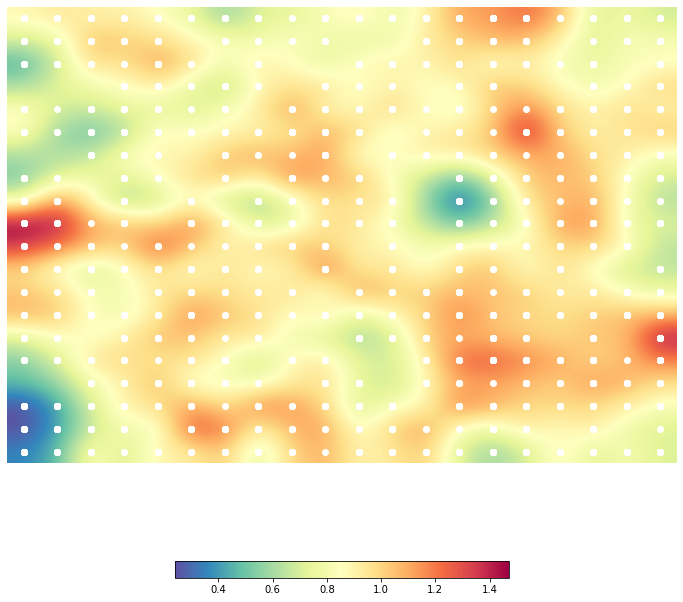

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [232]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(12, 12))

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


### Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [157]:
joblib.dump(som, 'som.pkl') 

['som.pkl']

### Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

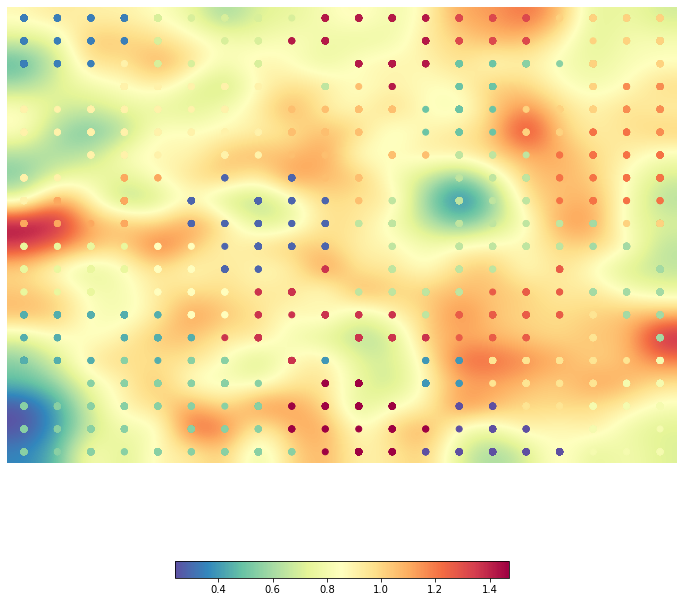

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [233]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=25)
som.cluster(algorithm=clustering)

som.view_umatrix(bestmatches=True, colorbar=True, figsize=(12, 12))

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

In [234]:
for row in som.clusters:
  print(row)

[ 2  2  2  2  9  9  9  9  9 23 23 23 23 21 21 21 15 15 15 15]
[ 2  2  2  2  9  9  9  9 23 23 23 23 23 21 21 21  6 15 15 15]
[ 2  2  2 13  9  9 13  9  9 23 23 23 23  5  5  6  6 15 15 15]
[ 2  2 13 13 13 13 13 13  9  8 16 23  5  5  5  5 15 15 18 18]
[13 13 13 13 13 13 13 13 16 16 16 16  5  5  5 15 15 15 18 18]
[13 13 13 13 13 13 13 13 16 16 16 16  5  5  5 15 15 19 19 18]
[13 13 13 13 13 13 13 13 16 16 16 16 16  8  8  8 19 19 19 19]
[13 13 17 17 17  1  1  1  1 16 16 16  8  8  8  8 19 19 19 19]
[13 17 17 17 17  1  1  1  1  1 16  8  8  8  8  8 19 19 19 19]
[17 17 17 17 17  1  1  1  1  1  8  8  8  8  8  8  8  7 15 15]
[10 10 10 10 12 12  1  1  1  1  8  8  8  8  8  8  8  7  7  7]
[10 10 10 10 12 12  1  1  1 22  8  8  8  8  8 20 20  7  7  7]
[10 10 10  4 12 12 12 22 22 22  8  8  8  8 20 20 20  7  7  7]
[ 4  4  4  4  4 12 12 22 22 22 22 22  8 20 20 20 20 14  7  7]
[ 4  4  4  4  4  4 22 22 22 22 22 22 22 20 20 20 14 14 14  7]
[ 4  4  4  6  4  6  6 22 22  3  3  3  3  3 14 14 14 14 14 11]
[ 6  6  

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">




### Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   


### Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




### Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook (η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας).

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.



Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.
